<a href="https://colab.research.google.com/github/Sanchitraj23/Cashew_Project/blob/main/Cashew_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [97]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [98]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/cashew_dataset/cashew",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3572 files belonging to 3 classes.


In [99]:
class_names = dataset.class_names
class_names

['anthracnose', 'healthy', 'red rust']

In [100]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 1 0 2 0 2 2 2 2 0 1 2 1 0 0 0 1 2 2 1 0 0 0 0 2 2 2 1 2 0 1]


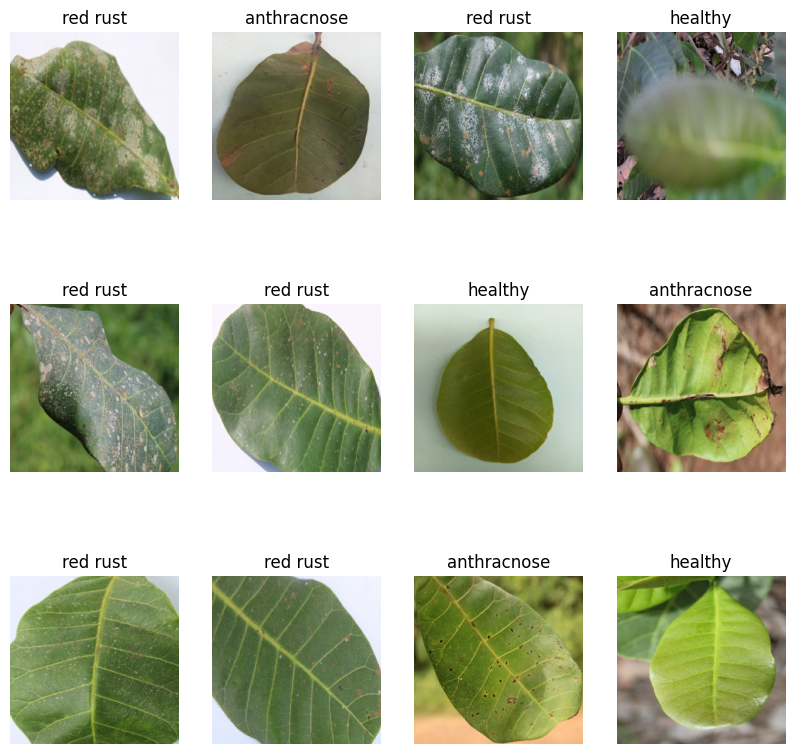

In [101]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to split datasets


In [102]:
len(dataset)

112

In [103]:
train_size = 0.8
len(dataset)*train_size

89.60000000000001

In [104]:
train_ds = dataset.take(54)
len(train_ds)

54

In [105]:
test_ds = dataset.skip(54)
len(test_ds)

58

In [106]:
val_size=0.1
len(dataset)*val_size

11.200000000000001

In [107]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [108]:
test_ds = test_ds.skip(6)
len(test_ds)

52

In [109]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [110]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [111]:
len(train_ds)

89

In [112]:
len(val_ds)

11

In [113]:
len(test_ds)

12

In [114]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [115]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [116]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [117]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [118]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [119]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)         

In [120]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [121]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
89/89 [==============================] - 421s 5s/step - loss: 0.8647 - accuracy: 0.5984 - val_loss: 0.7859 - val_accuracy: 0.6761
Epoch 2/50
89/89 [==============================] - 400s 4s/step - loss: 0.6536 - accuracy: 0.7281 - val_loss: 0.6725 - val_accuracy: 0.7017
Epoch 3/50
89/89 [==============================] - 399s 4s/step - loss: 0.5996 - accuracy: 0.7433 - val_loss: 0.5584 - val_accuracy: 0.7812
Epoch 4/50
89/89 [==============================] - 401s 5s/step - loss: 0.5725 - accuracy: 0.7574 - val_loss: 0.5589 - val_accuracy: 0.7614
Epoch 5/50
89/89 [==============================] - 387s 4s/step - loss: 0.5166 - accuracy: 0.7743 - val_loss: 0.5331 - val_accuracy: 0.7812
Epoch 6/50
89/89 [==============================] - 391s 4s/step - loss: 0.4684 - accuracy: 0.7955 - val_loss: 0.4340 - val_accuracy: 0.8011
Epoch 7/50
89/89 [==============================] - 395s 4s/step - loss: 0.4718 - accuracy: 0.7920 - val_loss: 0.4145 - val_accuracy: 0.8267
Epoch 8/50
89

In [122]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 32s 1s/step - loss: 0.1370 - accuracy: 0.9651


In [123]:
scores

[0.13703396916389465, 0.9650537371635437]

In [124]:
history

In [125]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 89}

In [126]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [127]:
type(history.history['loss'])

list

In [128]:
len(history.history['loss'])

50

In [129]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8647415041923523,
 0.6535676717758179,
 0.5996400117874146,
 0.5724743604660034,
 0.5165724158287048]

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

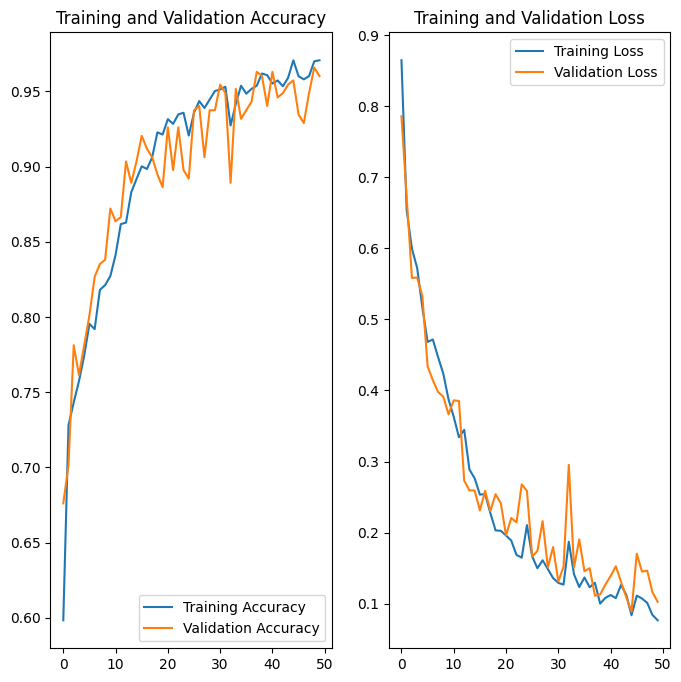

In [131]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: anthracnose
1/1 [==============================] - 1s 1s/step
predicted label: anthracnose


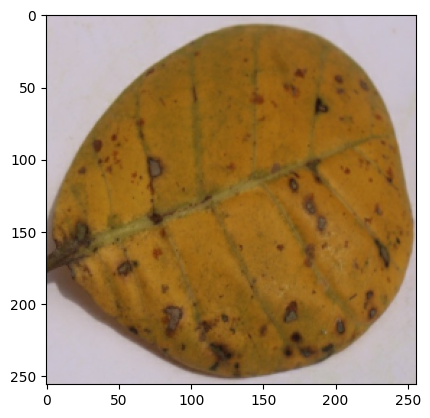

In [132]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [133]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


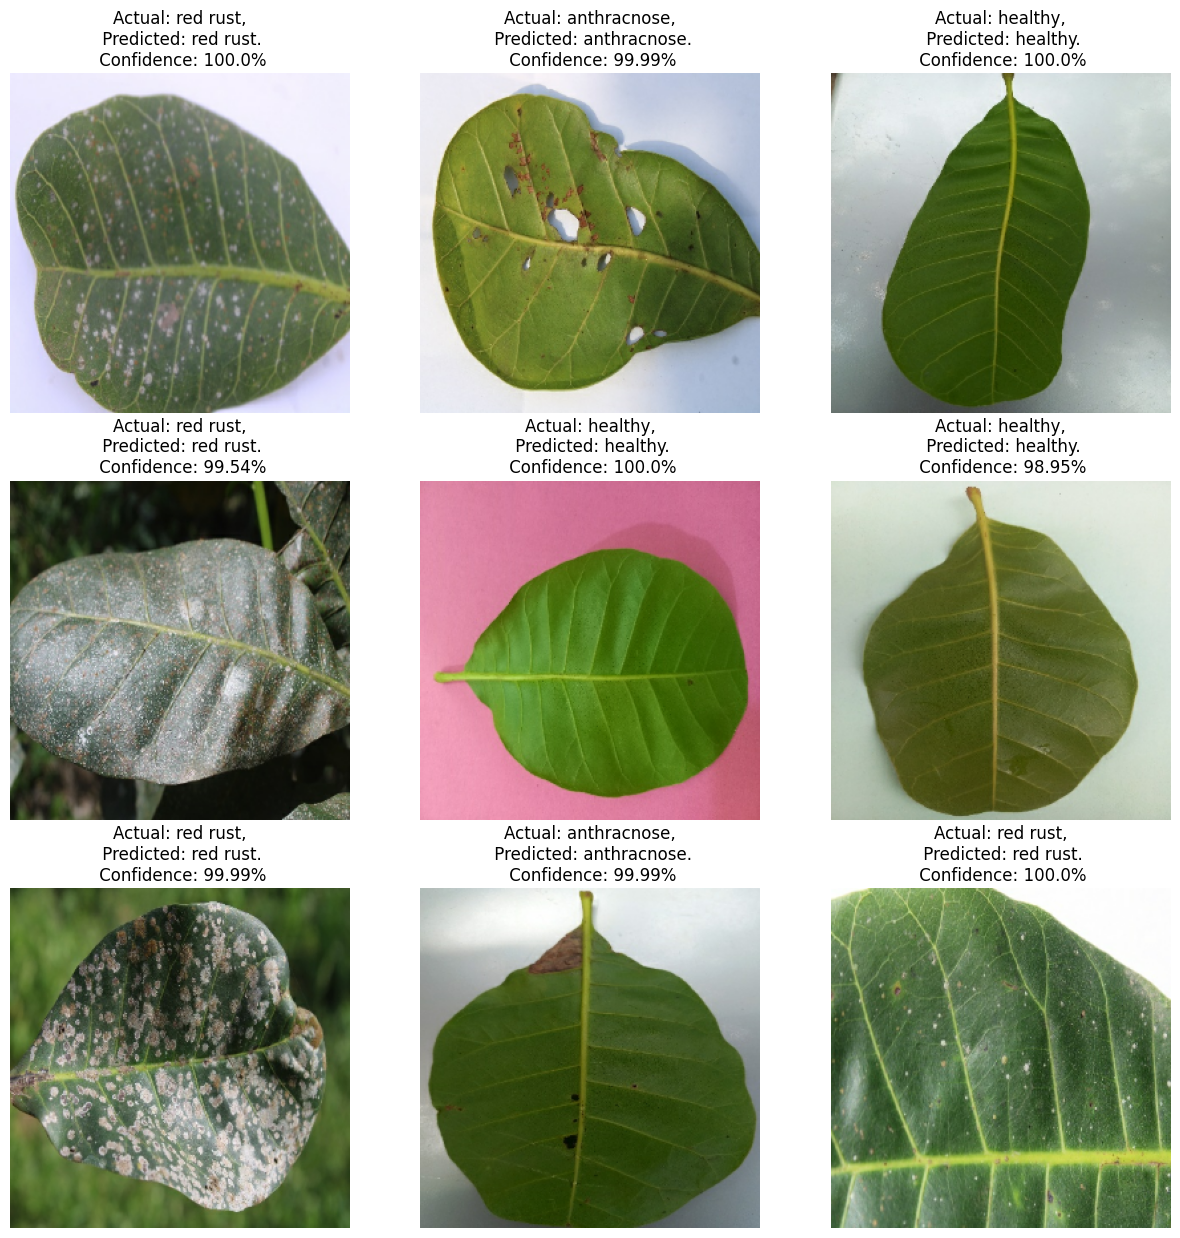

In [134]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")